In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    SoftPhongShader,
    MeshRasterizer,  
    HardPhongShader,
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
def __output_log(path, strs):
    if not os.path.exists(path):
        with open(path, 'w+') as f:
            f.write(strs)
            f.close()
    else:
        with open(path, 'a+') as f:
            f.write(strs)
            f.close()
def get_path(func):  
    if type(func).__name__ == 'function' : 
        return func.__code__.co_filename
    else: 
        raise ValueError("'func' must be a function") 


def draw_triangle(p, v1, v2, v3):
    p.plot([v1[0], v2[0]], [v1[1], v2[1]], c='r')
    p.plot([v2[0], v3[0]], [v2[1], v3[1]], c='g')
    p.plot([v3[0], v1[0]], [v3[1], v1[1]], c='b')
print(now_str())
print(torch.__version__)
print(torch.version.cuda)
print(get_path(load_obj))

[05/08 00:13:58]
1.4.0
9.2
d:\1_projects\200323_pytorch3dstart\pytorch3d\io\obj_io.py


In [2]:
print('torch.cuda.is_available():',torch.cuda.is_available())

device = torch.device("cuda:0")
torch.cuda.set_device(device)
print('----- torch.cuda.empty_cache() -----')

torch.cuda.empty_cache()
bytes_reserved = torch.cuda.memory_reserved()
print('torch.cuda.memory_reserved(): {:,.2f} Mb'.format(bytes_reserved * 0.000001))
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

torch.cuda.is_available(): True
----- torch.cuda.empty_cache() -----
torch.cuda.memory_reserved(): 0.00 Mb
torch.cuda.memory_allocated(): 0.00 Mb
torch.cuda.memory_cached(): 0.00 Mb


# settings

In [4]:
p_image_sizes = [256]
p_num_cams = [16]
p_batch_size = [8]
p_use_texture = [True]
p_target_offset_dist = [-1] # -1: random deform
p_blur_radius = [0]
p_faces_per_pixel = [5]
texturemap_res = 32
texturemap_size = 1024
p_sigma = [1e-4]
p_gamma = [1e-4]
p_use_scheduler = [True]
p_loss_type = ['rgba']
# p_loss_type = ['a']
deforms = ['verts_deform', 'translate', 'spherical_coord']
nnParameter_type = deforms[0]
assert(len(p_batch_size) == len(p_num_cams))
p_params = []
lr = 0.01

for _, image_size in enumerate(p_image_sizes):
    for i2, num_cams in enumerate(p_num_cams):
        for _, use_texture in enumerate(p_use_texture):
            for _, loss_type in enumerate(p_loss_type):
                for _, target_offset in enumerate(p_target_offset_dist):
                    for _, blur_radius in enumerate(p_blur_radius):
                        for _, faces_per_pixel in enumerate(p_faces_per_pixel):
                            for _, sigma in enumerate(p_sigma):
                                for _, gamma in enumerate(p_gamma):
                                    for _, use_scheduler in enumerate(p_use_scheduler):
                                        p_params.append(
                                            {
                                             'index': len(p_params),
                                             'nnParameter_type': nnParameter_type,
                                             'image_size': image_size,
                                             'num_cams': num_cams,
                                             'batch_size': p_batch_size[i2],
                                             'use_texture': use_texture,
                                             'texturemap_size': texturemap_size,
                                             'texturemap_res': texturemap_res,
                                             'loss_type': loss_type,
                                             'faces_per_pixel': faces_per_pixel,
                                             'target_offset': target_offset,
                                             'blur_radius': blur_radius,
                                             'sigma': sigma,
                                             'gamma': gamma,
                                             'lr': lr,
                                             'use_scheduler': use_scheduler}
                                            )
print('{} settings'.format(len(p_params)))
def params2string(idx, n_settings, p):
    str_out = '--- [Setting {}/{}] ----------------------\n'.format(idx + 1, n_settings)
    i = 1
    for k, v in p.items():
        if type(v) == str:
            str_out += '{:>2}. {:17}= {}'.format(i, k, v)
        elif isinstance(v, int):
            str_out += '{:>2}. {:17}= {:d}'.format(i, k, v)
        else:
            str_out += '{:>2}. {:17}= {:.4f}'.format(i, k, v)
        str_out += '\n'
        i += 1
    str_out += '\n'
    return str_out

setting_idx = 0
param_str = params2string(setting_idx, len(p_params), p_params[setting_idx])
print(param_str)


def export_params(params, export_dir):
    with open(export_dir + '/parameters.json', 'w+') as f:
        json.dump(params, f, indent=4)
    print('saved to:', export_dir)
          
export_dir = './10_data/output'
if not os.path.exists(export_dir):
    os.mkdir(export_dir)
export_params(p_params, export_dir)

1 settings
--- [Setting 1/1] ----------------------
 1. index            = 0
 2. nnParameter_type = verts_deform
 3. image_size       = 256
 4. num_cams         = 16
 5. batch_size       = 8
 6. use_texture      = 1
 7. texturemap_size  = 1024
 8. texturemap_res   = 32
 9. loss_type        = rgba
10. faces_per_pixel  = 5
11. target_offset    = -1
12. blur_radius      = 0
13. sigma            = 0.0001
14. gamma            = 0.0001
15. lr               = 0.0100
16. use_scheduler    = 1


saved to: ./10_data/output


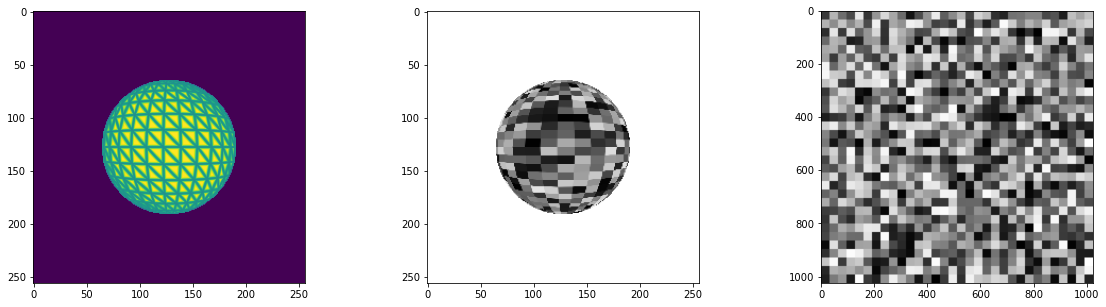

In [5]:
def gen_mesh(mesh_path, device, s, deform=False):
    verts, faces, aux = load_obj(mesh_path)
    use_texturemap = s['use_texture']
    target_offset = s['target_offset']
    np.random.seed(111*len(verts))
    
    faces_idx = faces.verts_idx
    if use_texturemap:
        texturemap_res = s['texturemap_res']
        texturemap_shape = (texturemap_res, texturemap_res, 1)
        texturemap_np = np.random.rand(texturemap_shape[0], texturemap_shape[1], 1).astype(np.float32)
        if texturemap_np.shape[-1] < 2:
            texturemap_np = np.dstack([texturemap_np, texturemap_np, texturemap_np])
        # texturemap_np = Image.open('./1_data/cow_mesh' + '/cow_texture.png')
        # texturemap_np = texturemap_np.convert('RGB')
        # texturemap_np = np.asarray(texturemap_np).astype(np.float32)
        texturemap_size = s['texturemap_size']
        texturemap_np = cv2.resize(texturemap_np, (texturemap_size, texturemap_size), interpolation=cv2.INTER_NEAREST)
#         texturemap_np = cv2.resize(texturemap_np, (texturemap_size, texturemap_size), interpolation=cv2.INTER_LINEAR)
        texturemap_np = np.expand_dims(texturemap_np, axis=0)
        # texturemap_np /= 255.0
        texture_map_torch = torch.from_numpy(texturemap_np).to(device)
        texture_map = nn.Parameter(texture_map_torch, requires_grad=False)
        verts_uvs = aux.verts_uvs[None, ...].to(device)  # (1, V, 2)
        faces_uvs = faces.textures_idx[None, ...].to(device)  # (1, F, 3)
        verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
        
        textures = Textures(maps=texture_map, faces_uvs=faces_uvs, verts_uvs=verts_uvs, verts_rgb=verts_rgb.to(device)).to(device)
    else:
        verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
#         verts_rgb[:, 0, :] = torch.tensor([1.0, 0.0, 0.0])
#         verts_rgb[:, 1, :] = torch.tensor([0.0, 1.0, 0.0])
#         verts_rgb[:, 2, :] = torch.tensor([0.0, 0.0, 1.0])
#         if verts_rgb.shape[1] > 3:
#             verts_rgb[:, 3, :] = torch.tensor([1.0, 1.0, 0.0])

        textures = Textures(verts_rgb=verts_rgb.to(device)).to(device)

    # Create a Meshes object for the teapot. Here we have only one mesh in the batch.
    mesh = Meshes(
        verts=[verts.to(device)],   
        faces=[faces_idx.to(device)], 
        textures=textures
    )

    # deform mesh
    if deform:
        verts = mesh.verts_packed().detach().cpu().numpy()
        if target_offset < 0:
            # dverts_target = (np.random.rand(verts.shape[0], 3).astype(np.float32) - 0.5)
            verts_norm = mesh.verts_normals_packed().detach().cpu().numpy()
            dverts_target = verts_norm * 0.1
        else:
            dverts_target = np.zeros((verts.shape[0], 3)).astype(np.float32)
            dverts_target = dverts_target.astype(np.float32)
            dverts_target = dverts_target + np.array([target_offset, target_offset, 0.0]).astype(np.float32)
        dverts_target = torch.from_numpy(dverts_target).to(device)
        mesh = mesh.offset_verts(dverts_target)
    return mesh

distance = 4   # distance from camera to the object
elevation = 0.0   # angle of elevation in degrees
azimuth = 150.0  # No rotation so the camera is positioned on the +Z axis. 
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
raster_settings = RasterizationSettings(
    image_size=p_image_sizes[0], 
    blur_radius=0.0, #np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=1, 
)
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
a_diffuse = 0.0
a_ambient = 0.9
s = torch.from_numpy(np.zeros((1, 3)).astype(np.float32)).to(device)
d = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_diffuse).to(device)
a = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_ambient).to(device)
lights.specular_color = s
lights.diffuse_color = d
lights.ambient_color = a


in_dir = './10_data/input'
mesh_path = in_dir + '/sphere.obj'
param_idx = len(p_params)-1
param_idx = 0
mesh_target = gen_mesh(mesh_path, device, p_params[param_idx], deform=True)

if p_params[param_idx]['use_texture']:
    sample_renderer = MeshRenderer(
        rasterizer=MeshRasterizer(cameras=cameras,raster_settings=raster_settings),
        shader=TexturedSoftPhongShader(device=device, blend_params=blend_params, lights=lights)
    )
else:
    sample_renderer = MeshRenderer(
        rasterizer=MeshRasterizer(cameras=cameras,raster_settings=raster_settings),
        shader=SoftPhongShader(device=device, lights=lights, blend_params=blend_params)
    )
    
image_rendered = sample_renderer(meshes_world=mesh_target).detach().cpu().numpy().squeeze()
silhouette = image_rendered[..., 3]
image_rendered = image_rendered[..., :3]

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].imshow(silhouette)
ax[1].imshow(image_rendered)
if mesh_target.textures._maps_padded is not None:
    mesh_texturemaps = mesh_target.textures._maps_padded.detach().squeeze().cpu().numpy()
    ax[2].imshow(mesh_texturemaps, vmin=0, vmax=255)
else:
    ax[2].axis('off')
plt.show()

# Export obj

In [6]:
def export_obj(model, out_dir, vt_path=None, fname_suffix=''):
    out_name = 'learned_mesh'

    # export texturemap
    tm = model.mesh.textures.maps_padded()
    if tm is not None:
        tm = tm.squeeze().detach().cpu().numpy()
        tm = (tm*255.0).astype(np.uint8)
        cv2.imwrite(out_dir + '/texturemap.png', tm)
    
    # export mtl
    with open(out_dir + '/{}.mtl'.format(out_name), 'w+') as f:
        f.write('map_Kd texturemap.png\n')
        f.write('newmtl None\n')
        f.write('Ns 500\n')
        f.write('Ka 0.8 0.8 0.8\n')
        f.write('Kd 0.8 0.8 0.8\n')
        f.write('Ks 0.8 0.8 0.8\n')
        f.write('d 1\n')
        f.write('illum 2')
        f.close()
        
    
    vt_lines = []
    f_lines = []
    if vt_path is not None:
        with open(vt_path, 'r') as f:
            lines = f.readlines()
            for l in lines:
                v = l.split(' ')
                if v[0] == 'vt':
                    vt_lines.append(l)
                elif v[0] == 'f':
                    f_lines.append(l)
    else:
        vts = mesh[0].textures.verts_uvs_list()
        vts = vts[0].tolist()
        for vt in vts:
            vt_lines.append('vt {} {}\n'.format(vt[0], vt[1]))
        
    for mesh_idx in range(len(model.mesh)):
        out_path = out_dir + '/{}_{}{}.obj'.format(out_name, mesh_idx, fname_suffix)
        deformed_mesh = model.get_deformed_mesh(mesh[mesh_idx])

        verts = deformed_mesh.verts_packed()
        faces = deformed_mesh.faces_packed()
        vnormals = deformed_mesh.verts_normals_list()[0]
        fnormals = deformed_mesh.faces_normals_list()[0]

        assert(faces.shape[0] == fnormals.shape[0])
        assert(vnormals.shape[0] == verts.shape[0])
        with open(out_path, 'w+') as f:
            f.write('# OBJ file created by Hyojoon Park.\n')
            f.write('###########################\n')
            f.write('# Vertices:       {}\n'.format(verts.shape[0]))
            f.write('# Vertex normals: {}\n'.format(vnormals.shape[0]))
            f.write('# Faces:          {}\n'.format(faces.shape[0]))
            f.write('###########################\n')
            f.write('mtllib learned_mesh.mtl\n')
            for i in range(verts.shape[0]):
                f.write('vn {} {} {}\n'.format(vnormals[i][0], vnormals[i][1], vnormals[i][2]))
                f.write('v {} {} {}\n'.format(verts[i][0], verts[i][1], verts[i][2]))

            for vtl in vt_lines:
                f.write(vtl)

            if len(f_lines) > 0:
                for fl in f_lines:
                    f.write(fl)
            else:
                for i in range(faces.shape[0]):
                    f.write("f")
                    face = faces[i, :]
                    for fi in range(face.shape[0]):
                        f.write(' {0:.0f}//{0:.0f}//{0:.0f}'.format(face[fi] + 1, fnormals[fi] + 1))
    #                     f.write(' {0:.0f}'.format(face[fi]))
                    f.write("\n")

        print('[{}/{}] Obj exported to: {}'.format(mesh_idx+1, len(model.mesh), out_path))
        

1/1


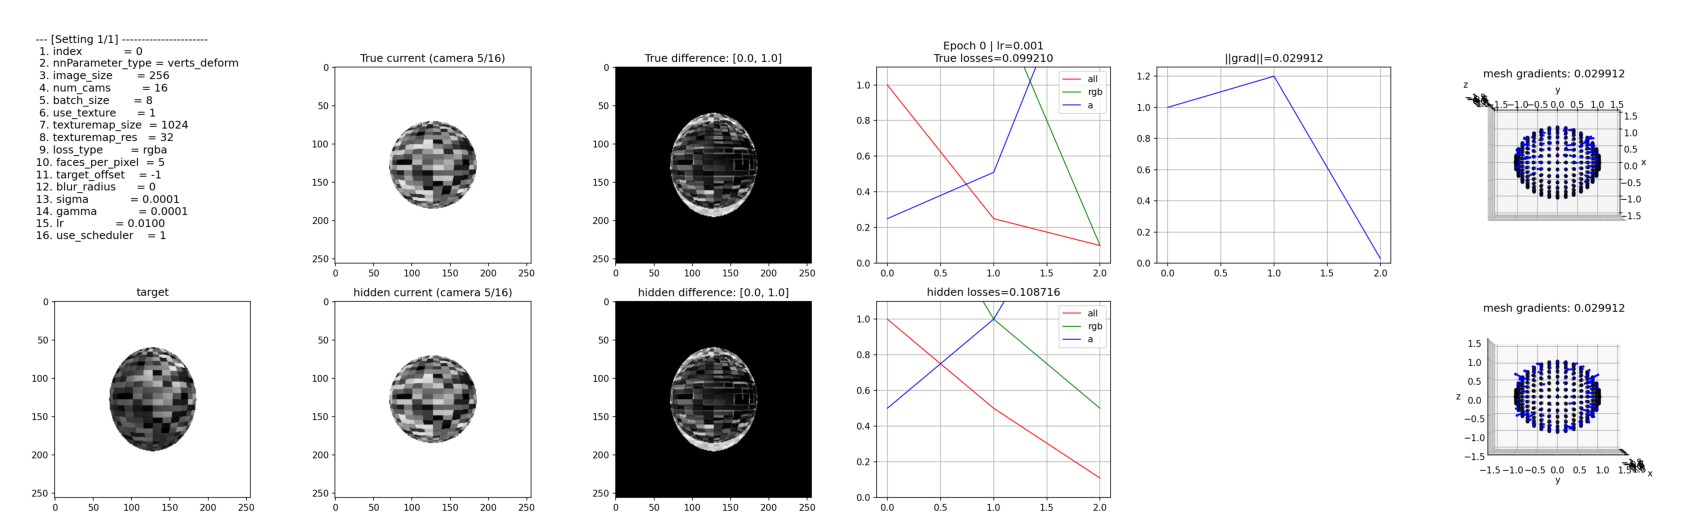

In [14]:
class Model(nn.Module):
    def __init__(self, device, **kwargs):
        super().__init__()
        
        self.device = device
        self.n_cams = kwargs.get('n_cams', None)
        self.cameras = None
        self.nnParameter_type = kwargs.get('nnParameter_type', None)
        self.image_size = kwargs.get('image_size', None)
        self.mesh = kwargs.get('mesh', None)
        self.mesh_target = kwargs.get('mesh_target', None)
        
        self.blend_params_for_loss = BlendParams(sigma=1e-4, gamma=1e-4)
        self.raster_settings_for_loss = RasterizationSettings(
            image_size=self.image_size, 
            blur_radius=0,
            faces_per_pixel=1, 
        )
        
        self.use_texture = kwargs.get('use_texture', None)
        self.loss_type = kwargs.get('loss_type', None)
        self.batch_size = kwargs.get('batch_size', None)
        self.n_batch = int(self.n_cams / self.batch_size)
        self.camera_batches = self._init_cameras()
        
        self.renderer = self._init_renderer()
        self.target_image_batches = self._init_target_images()
        
        # yaw, pitch, dist
        self.nnParameter_type = kwargs.get('nnParameter_type', None)

        if self.nnParameter_type == 'translate':
            self.center_offset = torch.from_numpy(np.zeros((3), dtype=np.float32)).to(self.device)
            self.center_offset = nn.Parameter(self.center_offset, requires_grad=True)
        elif self.nnParameter_type == 'verts_deform':
            self.dverts = torch.from_numpy(np.zeros((self.mesh.verts_packed().shape), dtype=np.float32)).to(self.device)
            self.dverts = nn.Parameter(self.dverts, requires_grad=True)
        elif self.nnParameter_type == 'spherical_coord':    
            self.offsets = torch.from_numpy(np.zeros((self.mesh.verts_packed().shape), dtype=np.float32)).to(self.device)
            self.offsets = nn.Parameter(self.offsets, requires_grad=True)
        else:
            print('No "nnParameter_type":', self.nnParameter_type)
            assert(False)
    def get_grad_value(self, mesh):
        if self.nnParameter_type == 'translate':
            grad_value = model.center_offset.grad
        elif self.nnParameter_type == 'verts_deform':
            grad_value = model.dverts.grad
        elif self.nnParameter_type == 'spherical_coord':    
            grad_value = model.offsets.grad
        else:
            grad_value = None
        return grad_value
    def get_deformed_mesh(self, mesh):
        if self.nnParameter_type == 'translate':
            dverts = []
            for _ in range(self.mesh.verts_packed().shape[0]):
                dverts.append(self.center_offset)
            dverts = torch.stack(dverts)
        elif self.nnParameter_type == 'verts_deform':
            dverts = self.dverts
        elif self.nnParameter_type == 'spherical_coord':  
            yaws = self.offsets[:, 0] * np.pi / 180.0
            pitches = self.offsets[:, 1] * np.pi / 180.0
            r = self.offsets[:, 2]
            cos_yaws = torch.cos(yaws)
            sin_yaws = torch.sin(yaws)
            cos_pitches = torch.cos(pitches)
            sin_pitches = torch.sin(pitches)
            dx = r*sin_pitches*cos_yaws
            dy = r*sin_pitches*sin_yaws
            dz = r*cos_pitches
            dverts = torch.stack([dx, dy, dz], dim=1)
        mesh_deformed = mesh.offset_verts(dverts)
        return mesh_deformed
    
    def forward(self, batch_idx, raster_settings, blend_params):
        target_images = self.target_image_batches[batch_idx]

        # ==================================================================================== #
        # minibatch training
        i0 = batch_idx*self.batch_size
        i1 = i0 + self.batch_size
        
        # batch preparation
        meshes = self.get_deformed_mesh(self.mesh)
        meshes = meshes.extend(self.batch_size)
        cam_batch = self.camera_batches[batch_idx]
        
        # render
        images = self.renderer(meshes_world=meshes, cameras=cam_batch, raster_settings=raster_settings, blend_params=blend_params)
        images_true = self.renderer(meshes_world=meshes, cameras=cam_batch, raster_settings=self.raster_settings_for_loss, blend_params=self.blend_params_for_loss)
        images_true = images_true.detach()
        
        # losses
        if self.loss_type == 'a':
            # loss for gradient
            loss_silhouette = torch.mean(torch.abs(images[..., 3] - target_images[..., 3]))
            loss_pixel = None
            loss = loss_silhouette
            # true loss
            loss_silhouette_true = torch.mean(torch.abs(images_true[..., 3] - target_images[..., 3]))
            loss_true = loss_silhouette_true
            loss_pixel_true = None
        elif self.loss_type == 'rgb':
            # loss for gradient
            loss_silhouette = None
            loss_pixel = torch.mean(torch.abs(images[..., :3] - target_images[..., :3]))
            loss = loss_pixel
            # true loss
            loss_silhouette_true = None
            loss_pixel_true = torch.mean(torch.abs(images_true[..., :3] - target_images[..., :3]))
            loss_true = loss_pixel_true
        elif self.loss_type == 'rgba':
            # loss for gradient
            loss_pixel = torch.mean(torch.abs(images[..., :3] - target_images[..., :3]))
            loss_silhouette = torch.mean(torch.abs(images[..., 3] - target_images[..., 3]))
            loss = loss_pixel + loss_silhouette
            # true loss
            loss_pixel_true = torch.mean(torch.abs(images_true[..., :3] - target_images[..., :3]))
            loss_silhouette_true = torch.mean(torch.abs(images_true[..., 3] - target_images[..., 3]))
            loss_true = loss_pixel_true + loss_silhouette_true
        else:
            assert(False)
        
        
        loss_dict = {'all': loss, 'pixel': loss_pixel, 'silhouette': loss_silhouette}
        true_loss_dict = {'all': loss_true, 'pixel': loss_pixel_true, 'silhouette': loss_silhouette_true}
        image_dict = {'images': images, 'target_images': target_images}
        image_true_dict = {'images': images_true}
        return image_dict, image_true_dict, loss_dict, true_loss_dict
    
    def _iou(self, S1, S2):
        S1S2 = torch.mul(S1, S2)
        return torch.mean(1.0 - torch.sum(torch.abs(S1S2)) / torch.sum(torch.abs(S1+S2-S1S2)))
    
    def _init_target_images(self):
        meshes = self.mesh_target.extend(self.batch_size)
        
        lights = PointLights(device=self.device, location=((2.0, 2.0, -2.0),)).to(self.device)
        a_diffuse = 0.7
        a_ambient = 0.4
        s = torch.from_numpy(np.zeros((1, 3)).astype(np.float32)).to(self.device)
        d = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_diffuse).to(self.device)
        a = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_ambient).to(self.device)
        lights.specular_color = s
        lights.diffuse_color = d
        lights.ambient_color = a
        
        rasterizer = MeshRasterizer(cameras=self.cameras, raster_settings=raster_settings)
        
        if self.use_texture:
            shader=TexturedSoftPhongShader(device=self.device, lights=lights, blend_params=blend_params)
        else:
            shader=SoftPhongShader(device=self.device, lights=lights, blend_params=blend_params)
        
        renderer = MeshRenderer(
            rasterizer=rasterizer,
            shader=shader
        )
        
        
        
        target_image_batches = []
        for batch_idx in range(self.n_batch):
            cam_batch = self.camera_batches[batch_idx]
            target_images = renderer(meshes_world=meshes, cameras=cam_batch, raster_settings=self.raster_settings_for_loss, blend_params=self.blend_params_for_loss)
            target_image_batches.append(target_images)
            
        return target_image_batches
        
    def _init_cameras(self):
        d_angle = 360.0 / self.n_cams
        camera_batches = []
        for batch_idx in range(self.n_batch):
            i0 = batch_idx*self.batch_size
            i1 = i0 + self.batch_size
            
            R_batch = torch.empty([batch_size, 3, 3])
            T_batch = torch.empty([batch_size, 3])
            for i in range(self.batch_size):
                distance = 4
                elevation = 0.0
                azimuth = d_angle * (i0 + i)
                Ri, Ti = look_at_view_transform(distance, elevation, azimuth, device=self.device)
                R_batch[i] = Ri.squeeze()
                T_batch[i] = Ti.squeeze()
            cam_batch = OpenGLPerspectiveCameras(device=self.device, R=R_batch, T=T_batch)
            camera_batches.append(cam_batch)
        return camera_batches
            
    def _init_renderer(self):
        blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
        raster_settings = RasterizationSettings(
            image_size=self.image_size, 
            blur_radius=0, #np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
            faces_per_pixel=1, 
        )
        
        
        lights = PointLights(device=self.device, location=((2.0, 2.0, -2.0),)).to(self.device)
        a_diffuse = 0.0
        a_ambient = 0.9
        s = torch.from_numpy(np.zeros((1, 3)).astype(np.float32)).to(self.device)
        d = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_diffuse).to(self.device)
        a = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_ambient).to(self.device)
        lights.specular_color = s
        lights.diffuse_color = d
        lights.ambient_color = a
        
        rasterizer = MeshRasterizer(cameras=self.cameras, raster_settings=raster_settings)
        
        if self.use_texture:
            shader=TexturedSoftPhongShader(device=self.device, lights=lights, blend_params=blend_params)
        else:
            shader=SoftPhongShader(device=self.device, lights=lights, blend_params=blend_params)
        
        renderer = MeshRenderer(
            rasterizer=rasterizer,
            shader=shader
        )
            
        return renderer

    
def render_plots(return_image, is_cuda, out_dir, e, param_idx, params, cam_idx, model, lr, losses, losses_true, grad_values, grad_norms, image_true, image, image_target):
    loss_type = params[param_idx]['loss_type']
    diff_true = np.abs(image_target-image_true)
    diff      = np.abs(image_target-image     )
    
    if is_cuda:
        max_loss = max(max(losses_true['all']), max(losses['all'])).cpu().numpy()
    else:
        max_loss = max(max(losses_true['all']), max(losses['all']))
    
    fig, ax = plt.subplots(2, 6, figsize=(26, 8), tight_layout=True)
    
    a_stat = ax[0, 0]
    a_tloss = ax[0, 3]
    a_tcurr = ax[0, 1]
    a_tdiff = ax[0, 2]
    a_gradnorm = ax[0, 4]
    a_gradvec1 = ax[0, 5]
    a_target = ax[1, 0]
    a_loss = ax[1, 3]
    a_curr = ax[1, 1]
    a_diff = ax[1, 2]
    a_gradvec2 = ax[1, 5]
    a_gradvec3 = ax[1, 4]
    
    a_tloss.plot(losses_true['all'], linewidth=1, c='r')
    a_tloss.set_title('Epoch {} | lr={}\nTrue losses={:.6f}'.format(e, lr, losses_true['all'][-1]))
    if model.loss_type == 'rgba':
        a_tloss.plot(losses_true['pixel'], linewidth=1, c='g')
        a_tloss.plot(losses_true['silhouette'], linewidth=1, c='b')
        a_tloss.legend(['all', 'rgb', 'a'])
    a_tloss.grid()
    a_tloss.set_ylim(bottom=0, top=max_loss*1.1)
    
    
    a_loss.plot(losses['all'], linewidth=1, c='r')
    a_loss.set_title('hidden losses={:.6f}'.format(losses['all'][-1]))
    if model.loss_type == 'rgba':
        a_loss.plot(losses['pixel'], linewidth=1, c='g')
        a_loss.plot(losses['silhouette'], linewidth=1, c='b')
        a_loss.legend(['all', 'rgb', 'a'])
    a_loss.grid()
    a_loss.set_ylim(bottom=0, top=max_loss*1.1)
    
    if loss_type == 'a':
        a_curr.imshow(image, cmap='gray')
        a_diff.imshow(diff, cmap='gray')
        a_tcurr.imshow(image_true, cmap='gray')
        a_tdiff.imshow(diff_true, cmap='gray')
        a_target.imshow(image_target, cmap='gray')
    else:
        a_curr.imshow(image)
        a_diff.imshow(diff)
        a_tcurr.imshow(image_true)
        a_tdiff.imshow(diff_true)
        a_target.imshow(image_target)
        
    a_curr.set_title('hidden current (camera {}/{})'.format(cam_idx+1, model.n_cams))
    a_tcurr.set_title('True current (camera {}/{})'.format(cam_idx+1, model.n_cams))
    a_target.set_title('target')
    
    a_diff.set_title('hidden difference: [{:.1f}, {:.1f}]'.format(np.min(diff), np.max(diff)))
    a_tdiff.set_title('True difference: [{:.1f}, {:.1f}]'.format(np.min(diff_true), np.max(diff_true)))
    
    param_str = params2string(param_idx, len(params), params[param_idx])
    a_stat.text(0, 0, param_str, fontsize=12)
    a_stat.axis('off')
    
    a_gradnorm.plot(grads, linewidth=1, c='b')
    a_gradnorm.set_title('||grad||={:.6f}'.format(grads[-1]))
    a_gradnorm.grid()
    a_gradnorm.set_ylim(bottom=0)
    
    
    a_gradvec1.axis('off')
    a_gradvec1 = fig.add_subplot(2, 6, 6, projection='3d')
    verts = model.mesh.verts_packed().detach().cpu().numpy()
    mesh_verts = model.mesh.verts_packed().detach().cpu().numpy()
    if model.nnParameter_type == 'translate':
        verts = np.mean(mesh_verts, axis=0)
        
    a_gradvec1.set_title('mesh gradients: {:.6f}'.format(grad_norms[-1]))
    grad_values /= grad_norms[-1]
    if model.nnParameter_type == 'translate':
        a_gradvec1.quiver(verts[0], verts[1], verts[2], grad_values[0], grad_values[1], grad_values[2], normalize=False, lw=2, color='r')
        a_gradvec1.scatter(verts[0], verts[1], verts[2], c='k', s=10)
    elif model.nnParameter_type == 'verts_deform':
        a_gradvec1.quiver(verts[:,0], verts[:,1], verts[:,2], grad_values[:,0], grad_values[:,1], grad_values[:,2], normalize=False, lw=2, color='b')
    a_gradvec1.scatter(mesh_verts[:,0], mesh_verts[:,1], mesh_verts[:,2], c='k', s=10)
    a_gradvec1.view_init(elev=-90, azim=0)
    a_gradvec1.set_xlabel('x'), a_gradvec1.set_ylabel('y'), a_gradvec1.set_zlabel('z')
    a_gradvec1.quiver(np.array([0, 0, 0]), np.array([0, 0, 0]), np.array([0, 0, 0]), np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1]), color=['r', 'g', 'b'], linestyle=':', normalize=True, arrow_length_ratio=0)
    L = 1.5
    a_gradvec1.set_xlim([-L, L]), a_gradvec1.set_ylim([-L, L]), a_gradvec1.set_zlim([-L, L])
    
    a_gradvec2.axis('off')
    a_gradvec2 = fig.add_subplot(2, 6, 12, projection='3d')
    a_gradvec2.quiver(np.array([0, 0, 0]), np.array([0, 0, 0]), np.array([0, 0, 0]), np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1]), color=['r', 'g', 'b'], linestyle=':', normalize=True, arrow_length_ratio=0)
    verts = model.mesh.verts_packed().detach().cpu().numpy()
    mesh_verts = model.mesh.verts_packed().detach().cpu().numpy()
    if model.nnParameter_type == 'translate':
        verts = np.mean(mesh_verts, axis=0)
        
    a_gradvec2.set_title('mesh gradients: {:.6f}'.format(grad_norms[-1]))
    if model.nnParameter_type == 'translate':
        a_gradvec2.quiver(verts[0], verts[1], verts[2], grad_values[0], grad_values[1], grad_values[2], normalize=False, lw=2, color='r')
        a_gradvec2.scatter(verts[0], verts[1], verts[2], c='k', s=10)
    elif model.nnParameter_type == 'verts_deform':
        a_gradvec2.quiver(verts[:,0], verts[:,1], verts[:,2], grad_values[:,0], grad_values[:,1], grad_values[:,2], normalize=False, lw=2, color='b')
    a_gradvec2.scatter(mesh_verts[:,0], mesh_verts[:,1], mesh_verts[:,2], c='k', s=10)
    a_gradvec2.view_init(elev=0, azim=0)
    a_gradvec2.set_xlabel('x'), a_gradvec2.set_ylabel('y'), a_gradvec2.set_zlabel('z')
    a_gradvec2.set_xlim([-L, L]), a_gradvec2.set_ylim([-L, L]), a_gradvec2.set_zlim([-L, L])
    
    a_gradvec3.axis('off')
    out_path = out_dir + '/plot_{}.png'.format(e)
    plt.savefig(out_path, dpi=150)
    plt.close('all')
    
    if return_image:
        return imageio.imread(out_path)
    return None
    
torch.cuda.empty_cache()
param_idx = len(p_params)-1
in_dir = './10_data/input'
mesh_path = in_dir + '/sphere.obj'
mesh_target_path = in_dir + '/sphere_target.obj'
out_dir = './10_data/output'
for param_idx, p in enumerate(p_params):
    if param_idx < 0:
        continue
    print('{}/{}'.format(param_idx+1, len(p_params)))
    # print(params2string(param_idx, len(p_params), p))
    loss_type = p['loss_type']
    batch_size = p['batch_size']
    use_texture = p['use_texture']
    image_size = p['image_size']
    nnParameter_type = p['nnParameter_type']
    mesh_target = gen_mesh(mesh_target_path, device, p, deform=False)
    mesh = gen_mesh(mesh_path, device, p, deform=False)
    model = Model(device=device, mesh=mesh, mesh_target=mesh_target, nnParameter_type=nnParameter_type, loss_type=loss_type, n_cams=num_cams, batch_size=batch_size, use_texture=use_texture, image_size=image_size)

    # ================== #
    # test run
    blend_params = BlendParams(sigma=p['sigma'], gamma=p['gamma'])
    raster_settings = RasterizationSettings(
            image_size=image_size, 
            blur_radius=p['blur_radius'],
            faces_per_pixel=p['faces_per_pixel']
    )

    lr = p['lr']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = {'all': [], 'pixel': [], 'silhouette': []}
    losses_true = {'all': [], 'pixel': [], 'silhouette': []}
    optimizer.zero_grad()
    image_dict, image_true_dict, loss_dict, loss_true_dict = model(batch_idx=0, raster_settings=raster_settings, blend_params=blend_params)
    for k, v in loss_dict.items():
        if v is not None:
            vv = v.detach().cpu().numpy()
            losses[k].append(vv)
            losses_true[k].append(loss_true_dict[k].detach().cpu().numpy())
    loss = loss_dict['all']
    loss.backward()
    optimizer.step()
    # ================== #

    return_image = True
    e = 0
    cam_idx = 4

    losses = {'all': [1, 0.5, loss_dict['all']], 'pixel': [2, 1, 0.5], 'silhouette': [0.5, 1, 2]}
    losses_true = {'all': [1, 0.25, loss_true_dict['all']], 'pixel': [2, 1.5, 0.1], 'silhouette': [0.25, 0.51, 2.0]}
    if model.nnParameter_type == 'translate':
        grad_values = model.center_offset.grad.detach().cpu().numpy()
    elif model.nnParameter_type == 'verts_deform':
        grad_values = model.dverts.grad.detach().cpu().numpy()
    grad_norm = np.linalg.norm(grad_values)
    grads = [1, 1.2, grad_norm]
    image = image_dict['images'][cam_idx].detach().cpu().numpy()
    image_true = image_true_dict['images'][cam_idx].cpu().numpy()
    image_target = image_dict['target_images'][cam_idx].detach().cpu().numpy()

    if model.loss_type == 'a':
        image = image[..., 3]
        image_true = image_true[..., 3]
        image_target = image_target[..., 3]
    else:
        image = image[..., :3]
        image_true = image_true[..., :3]
        image_target = image_target[..., :3]
    
    plot_image = render_plots(return_image, False, out_dir, e, param_idx, p_params, cam_idx, model, 0.001, losses, losses_true, grad_values, grads, image_true, image, image_target)
    plt.figure(figsize=(30, 15))
    plt.imshow(plot_image)
    plt.axis('off')
    plt.show()
    break

outputs: ./10_data/output/sphere
##############################
./10_data/input/sphere.obj
##############################
Param_idx=0, total count=1 =====================================================================================
Log output: ./10_data/output/sphere/setting_0/log_20200508.txt


<ipython-input-15-af6728af6c05>:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  loop = tqdm_notebook(range(1000000000))


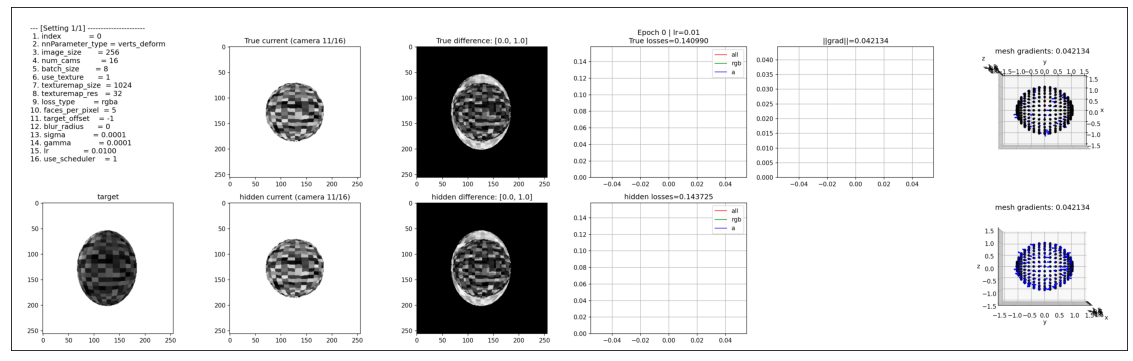

Epoch    31: reducing learning rate of group 0 to 9.0000e-03.
Epoch    45: reducing learning rate of group 0 to 8.1000e-03.
Epoch    49: reducing learning rate of group 0 to 7.2900e-03.
Epoch    73: reducing learning rate of group 0 to 6.5610e-03.
Epoch    77: reducing learning rate of group 0 to 5.9049e-03.
Epoch    81: reducing learning rate of group 0 to 5.3144e-03.
Epoch    85: reducing learning rate of group 0 to 4.7830e-03.
Epoch    89: reducing learning rate of group 0 to 4.3047e-03.
Epoch    95: reducing learning rate of group 0 to 3.8742e-03.
Epoch    99: reducing learning rate of group 0 to 3.4868e-03.
Epoch   103: reducing learning rate of group 0 to 3.1381e-03.
Epoch   107: reducing learning rate of group 0 to 2.8243e-03.
Epoch   111: reducing learning rate of group 0 to 2.5419e-03.
Epoch   115: reducing learning rate of group 0 to 2.2877e-03.
Epoch   119: reducing learning rate of group 0 to 2.0589e-03.
Epoch   123: reducing learning rate of group 0 to 1.8530e-03.
Epoch   

KeyboardInterrupt: 

In [15]:
%matplotlib inline
torch.cuda.empty_cache()
in_dir = './10_data/input'
obj_names = ['sphere']
out_folder = '10_data'
mesh_paths = []
for obj_name in obj_names:
    out_dir = './{}/output/{}'.format(out_folder, obj_name)
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    mesh_paths.append(in_dir + '/{}.obj'.format(obj_name))
    print('outputs:', out_dir)

for mesh_idx, mesh_path in enumerate(mesh_paths):
    print('##############################')
    print(mesh_path)
    print('##############################')
    for param_idx, params in enumerate(p_params):
#         if param_idx < 108:
#             continue
        print('Param_idx={}, total count={} ====================================================================================='.format(param_idx, len(p_params)))
        out_dir = './{}/output/{}/setting_{}'.format(out_folder, obj_names[mesh_idx], param_idx)
        if not os.path.exists(out_dir):
            os.mkdir(out_dir)
        gif_path = out_dir + '/plots.gif'
        out_path = out_dir + '/plot.png'
        
        # ====================== #
        # start
        now = datetime.now()
        date_str = '{}{:>02}{:>02}'.format(now.year, now.month, now.day)
        log_path = out_dir + '/log_{}.txt'.format(date_str)
        __output_log(log_path, '========== {} Start ==========================\n'.format(date_str))
        __output_log(log_path, params2string(param_idx, len(p_params), params))
        data_export_path = out_dir + '/data_{}.txt'.format(date_str)
        data_str = 'timestamp;epoch;loss_true;loss_rgb_true;loss_a_true;loss;loss_rgb;loss_a;grad_vec;grad_norm\n'
        __output_log(data_export_path, '========== {} Start ==========================\n'.format(date_str))
        __output_log(data_export_path, data_str)
        print('Log output: {}'.format(log_path))
        

        num_cams = params['num_cams']
        batch_size = params['batch_size']
        loss_type = params['loss_type']
        use_texture = params['use_texture']
        image_size = params['image_size']
        nnParameter_type = params['nnParameter_type']
        mesh_target = gen_mesh(mesh_target_path, device, params, deform=True)
        mesh = gen_mesh(mesh_path, device, params, deform=False)
        model = Model(device=device, mesh=mesh, mesh_target=mesh_target, nnParameter_type=nnParameter_type, loss_type=loss_type, n_cams=num_cams, batch_size=batch_size, use_texture=use_texture, image_size=image_size)

        

        lr = params['lr']
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=3, verbose=True)
        loop = tqdm_notebook(range(1000000000))

        cam_idx = 10
        sigma = params['sigma']
        gamma = params['gamma']
        blur_radius = params['blur_radius']
        faces_per_pixels = params['faces_per_pixel']
        blend_params = BlendParams(sigma=sigma, gamma=gamma)
        raster_settings = RasterizationSettings(
                    image_size=image_size, 
                    blur_radius=blur_radius,
                    faces_per_pixel=faces_per_pixel, 
        )

        images = []
        losses = {'all': [], 'pixel': [], 'silhouette': []}
        losses_true = {'all': [], 'pixel': [], 'silhouette': []}

        grads = []
        latest_states = {}
        for e in loop:
            t0 = time.time()
            export_plots = (e % 10 == 0)
            lr_curr = optimizer.param_groups[0]['lr']

            optimizer.zero_grad()

            loss_dict = {'all': 0.0, 'pixel': 0.0, 'silhouette': 0.0}
            loss_true_dict = {'all': 0.0, 'pixel': 0.0, 'silhouette': 0.0}
            image_dict = {'images': torch.empty(model.n_batch*model.batch_size, image_size, image_size, 4), 
                          'target_images': torch.empty(model.n_batch*model.batch_size, image_size, image_size, 4)}
            image_true_dict = {'images': torch.empty(model.n_batch*model.batch_size, image_size, image_size, 4)}

            for batch_idx in range(model.n_batch):
                img_dict, img_true_dict, l_dict, l_true_dict = model(batch_idx=batch_idx, raster_settings=raster_settings, blend_params=blend_params)
                loss = l_dict['all']
                loss_pixel = l_dict['pixel']
                loss_sil = l_dict['silhouette']
                
                loss_true = l_true_dict['all']
                loss_pixel_true = l_true_dict['pixel']
                loss_sil_true = l_true_dict['silhouette']
                
                loss.backward()
                optimizer.step()

                loss_dict['all'] += loss.data / model.n_batch
                loss_true_dict['all'] += loss_true.data / model.n_batch
                if loss_pixel is not None:
                    loss_dict['pixel'] += loss_pixel / model.n_batch
                    loss_true_dict['pixel'] += loss_pixel_true / model.n_batch
                if loss_sil is not None:
                    loss_dict['silhouette'] += loss_sil / model.n_batch
                    loss_true_dict['silhouette'] += loss_sil_true / model.n_batch

                i0 = batch_idx*model.batch_size
                i1 = i0 + model.batch_size
                image_dict['images'][i0:i1] = img_dict['images']
                image_dict['target_images'][i0:i1] = img_dict['target_images']
                image_true_dict['images'][i0:i1] = img_true_dict['images']

                
            loop.set_description('p[{}/{}] E[{}] lr({}) loss({:.3f})'.format(param_idx+1, len(p_params), e+1, lr_curr, loss_dict['all']))
            losses['all'].append(loss_dict['all'])
            losses_true['all'].append(loss_true_dict['all'])
            if loss_pixel is not None:
                losses['pixel'].append(loss_dict['pixel'])
                losses_true['pixel'].append(loss_true_dict['pixel'])
            else:
                losses['pixel'].append(-1)
                losses_true['pixel'].append(-1)
            if loss_sil is not None:
                losses['silhouette'].append(loss_dict['silhouette'])
                losses_true['silhouette'].append(loss_true_dict['silhouette'])
            else:
                losses['silhouette'].append(-1)
                losses_true['silhouette'].append(-1)

            # =============== #
            # plots
            # =============== 
            grad_value = model.get_grad_value(model.mesh[mesh_idx]).detach().cpu().numpy()
            grad_norm = np.linalg.norm(grad_value)
            grads.append(grad_norm)
            if export_plots:
                if loss_pixel is not None:
                    image_out = image_dict['images'][cam_idx, ..., :3]
                    image_out_true = image_true_dict['images'][cam_idx, ..., :3]
                    image_out_target = image_dict['target_images'][cam_idx, ..., :3]
                else:
                    image_out = image_dict['images'][cam_idx, ..., 3]
                    image_out_true = image_true_dict['images'][cam_idx, ..., 3]
                    image_out_target = image_dict['target_images'][cam_idx, ..., 3]
                image_out = image_out.detach().cpu().numpy()
                image_out_true = image_out_true.cpu().numpy()
                image_out_target = image_out_target.detach().cpu().numpy()

                if e == 0:
                    plot = render_plots(True, True, out_dir, e, param_idx, p_params, cam_idx, model, lr_curr, losses, losses_true, grad_value, grads, image_out_true, image_out, image_out_target)
                    plt.figure(figsize=(20, 10))
                    plt.imshow(plot)
                    plt.xticks([]), plt.yticks([])
                    plt.show()
                else:
                    _ = render_plots(False, True, out_dir, e, param_idx, p_params, cam_idx, model, lr_curr, losses, losses_true, grad_value, grads, image_out_true, image_out, image_out_target)

#                 cam_idx += 1
#                 if cam_idx >= model.n_cams:
#                     cam_idx = 0
            # =============== #
            # log
            # =============== #
            t1 = time.time()
            mb_alloc = torch.cuda.memory_allocated() * 0.000001
            mb_cached = torch.cuda.memory_cached() * 0.000001
            now = datetime.now()
            hour = str(now.hour)
            minute = str(now.minute)
            second = str(now.second)
            now_str = '{:>02}:{:>02}:{:>02}'.format(hour, minute, second)
            out_str = '{} | {:04} | {:.2f}s | lr={:.8f} | loss_all_true={:.6f}, loss_all={:.6f} | GPU_allocated({:,.2f}Mb) | GPU_cached({:,.2f}Mb)\n'.format(now_str, e+1, t1-t0, lr_curr, loss_true_dict['all'], loss_dict['all'], mb_alloc, mb_cached)
            __output_log(log_path, out_str)

            # cf) data_str = 'timestamp epoch loss loss_rgb loss_a grad_vec grad_norm\n'
            grad_value_str = np.array_repr(grad_value).replace('\n', '')
            data_str = '{};{};{};{};{};{};{};{};{};{}\n'.format(now_str, e, losses_true['all'][-1], losses_true['pixel'][-1], losses_true['silhouette'][-1], losses['all'][-1], losses['pixel'][-1], losses['silhouette'][-1], grad_value_str, grads[-1])
            __output_log(data_export_path, data_str)

            scheduler.step(loss)
            if lr_curr < 1e-10:
                print('lr={}. BREAK'.format(lr_curr))
                plot = render_plots(True, True, out_dir, e, param_idx, p_params, cam_idx, model, lr_curr, losses, losses_true, grad_value, grads, image_out_true, image_out, image_out_target)
                plt.figure(figsize=(20, 10))
                plt.imshow(plot)
                plt.xticks([]), plt.yticks([])
                plt.show()
                break

            if e > 1000:
                plot = render_plots(True, True, out_dir, e, param_idx, p_params, cam_idx, model, lr_curr, losses, losses_true, grad_value, grads, image_out_true, image_out, image_out_target)
                plt.figure(figsize=(20, 10))
                plt.imshow(plot)
                plt.xticks([]), plt.yticks([])
                plt.show()
                print('e={}. BREAK'.format(e))
                break
print('=========== DONE ===========')

In [ ]:
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)
print('gif saved:', gif_path)


### save final images for each camera

./10_data/output/sphere/setting_0


<ipython-input-14-1827e17eb3bb>:308: RuntimeWarning: invalid value encountered in true_divide
  grad_values /= grad_norms[-1]


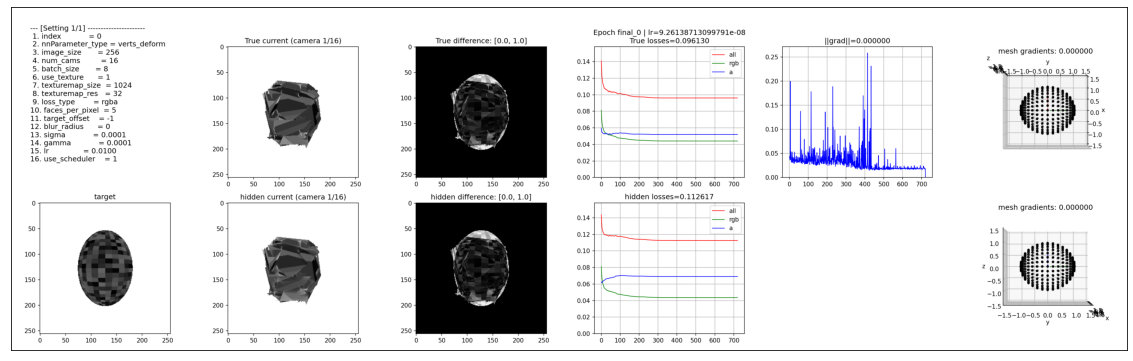

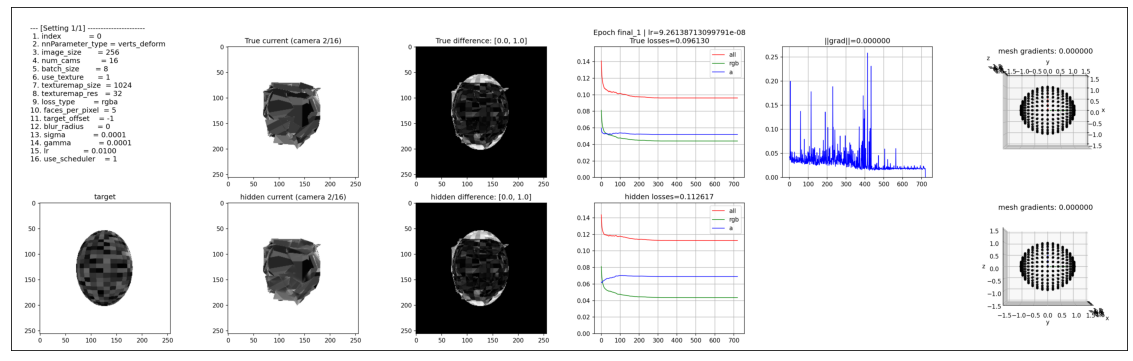

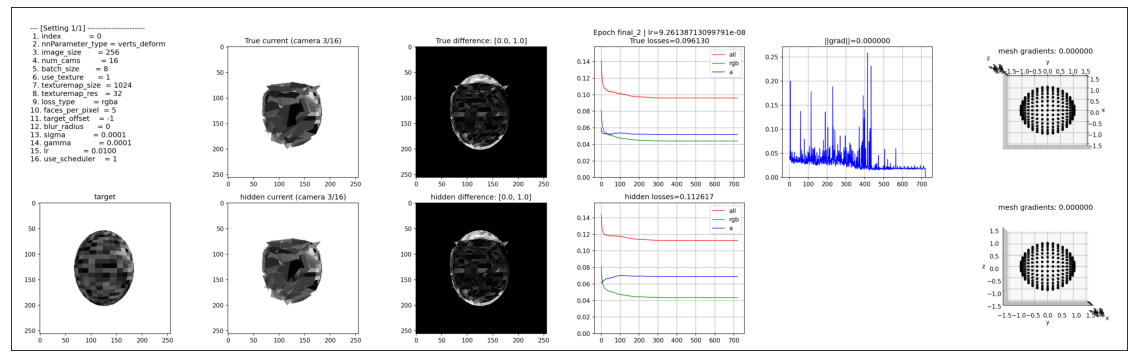

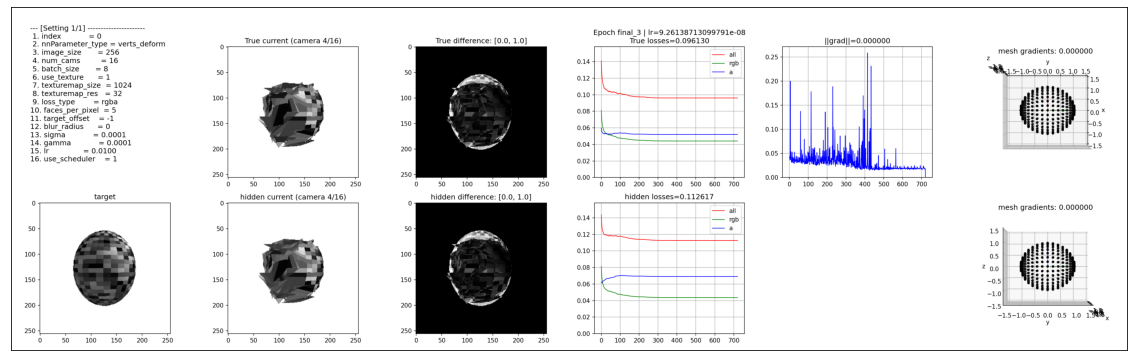

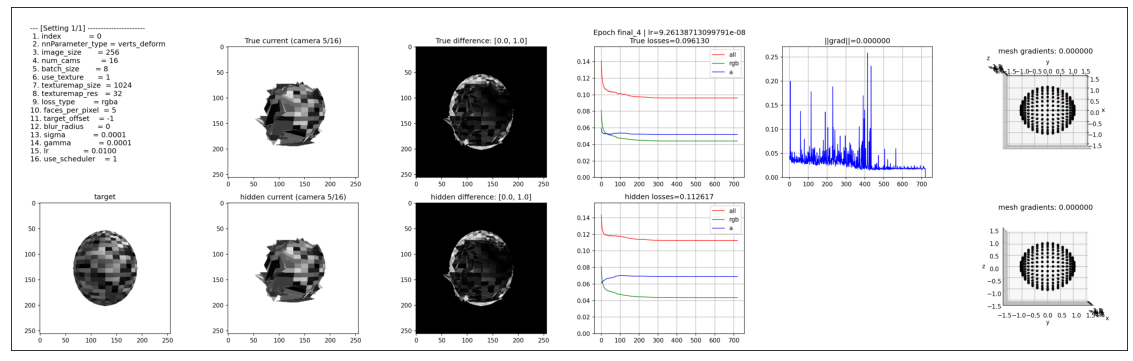

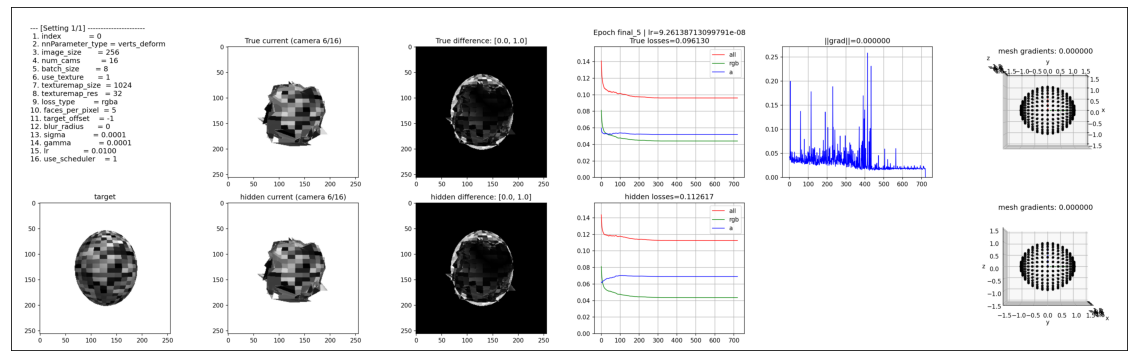

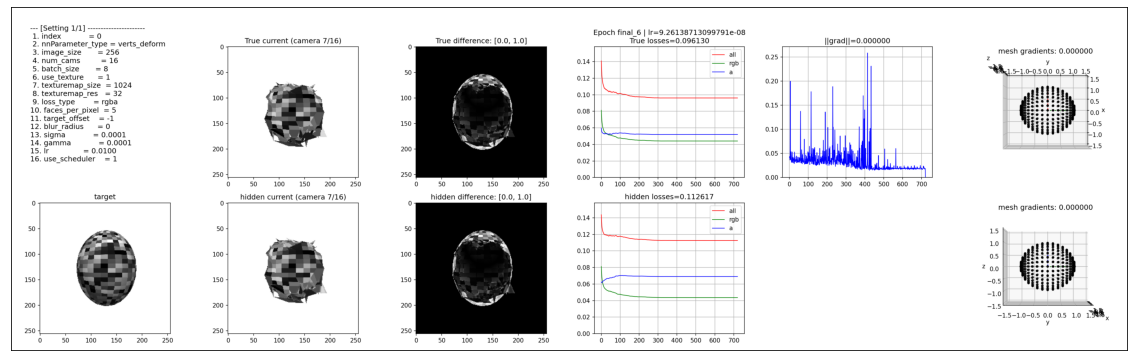

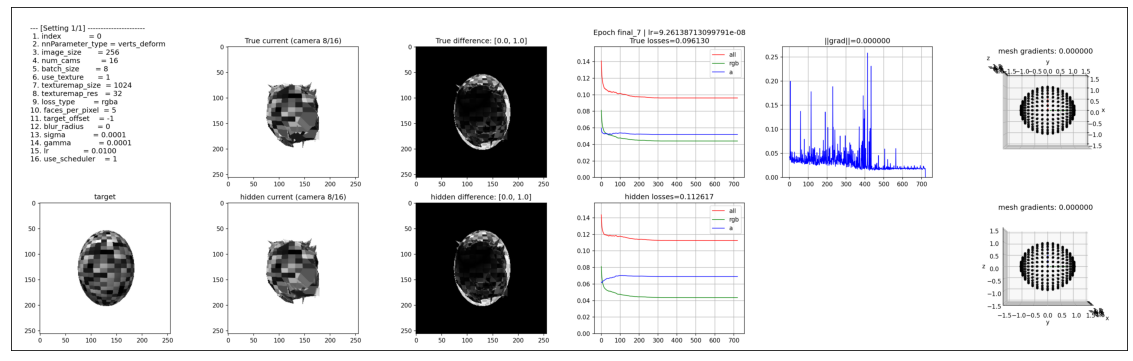

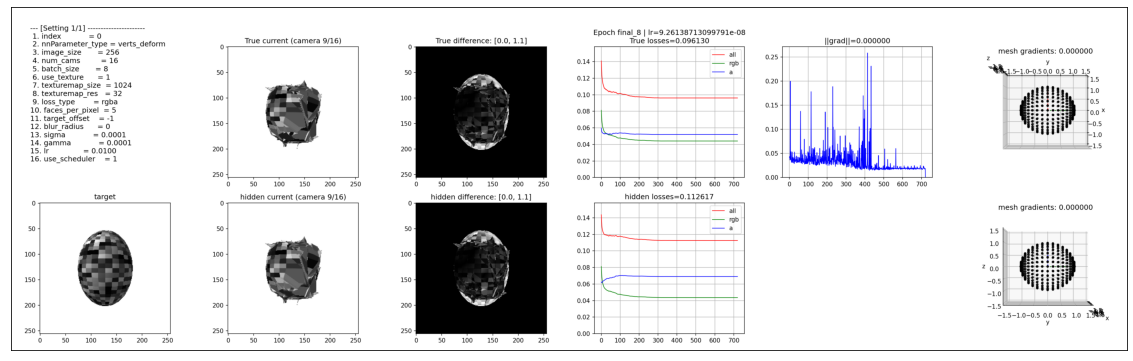

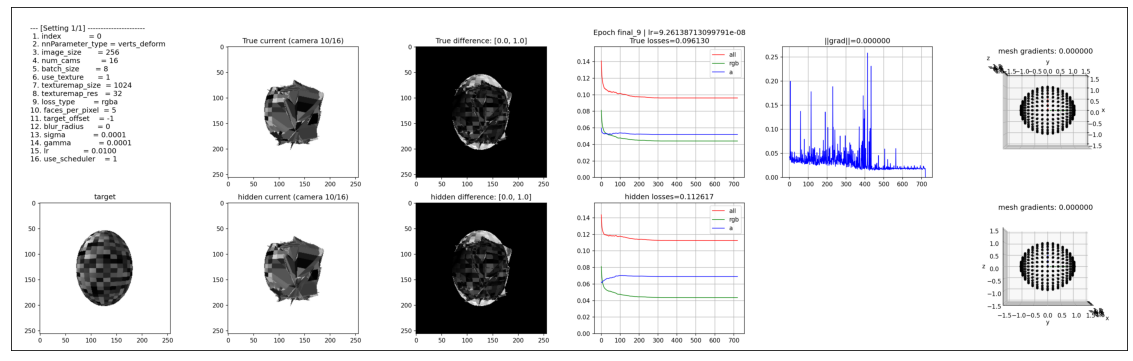

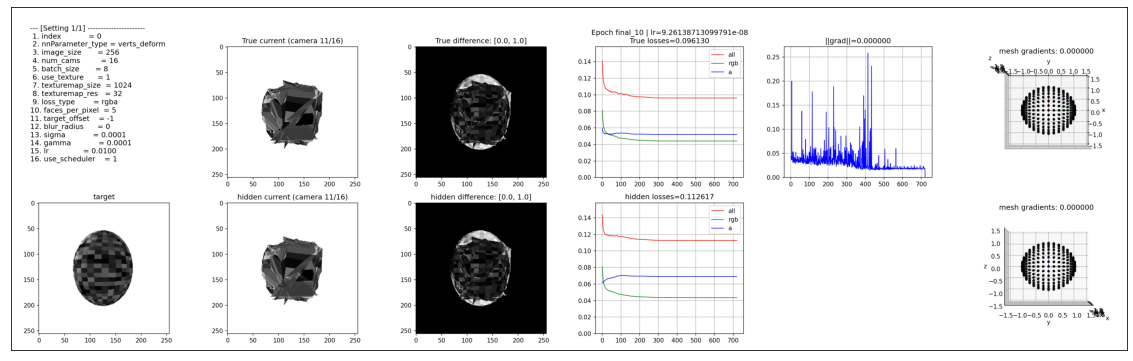

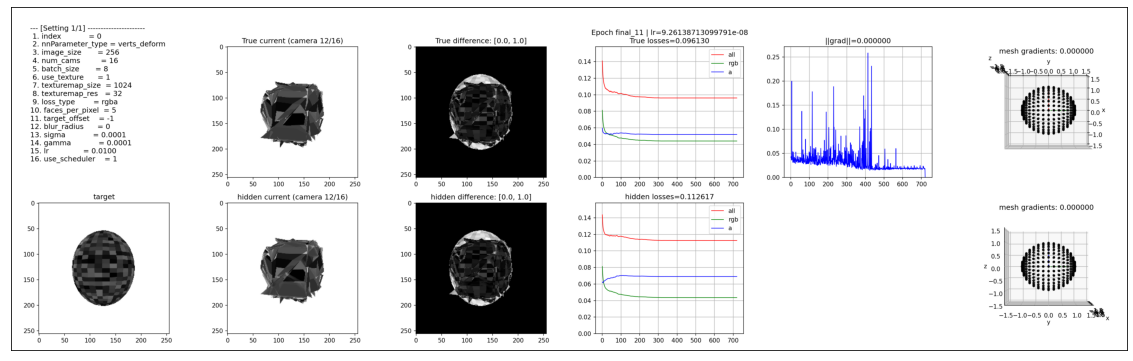

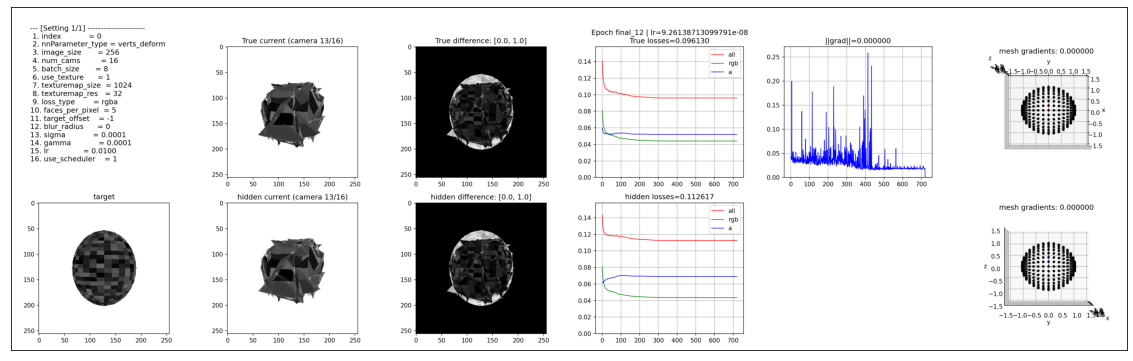

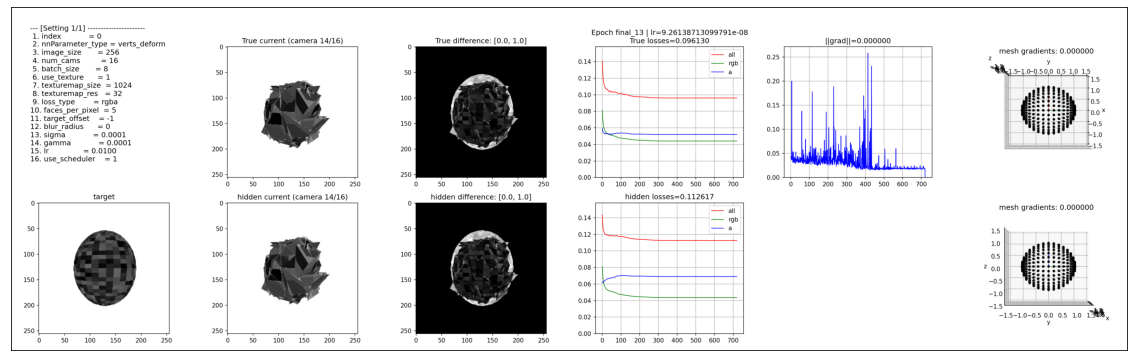

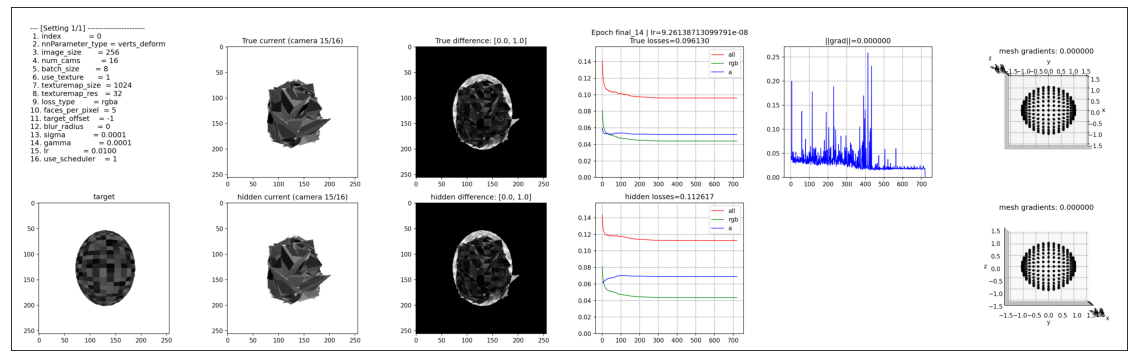

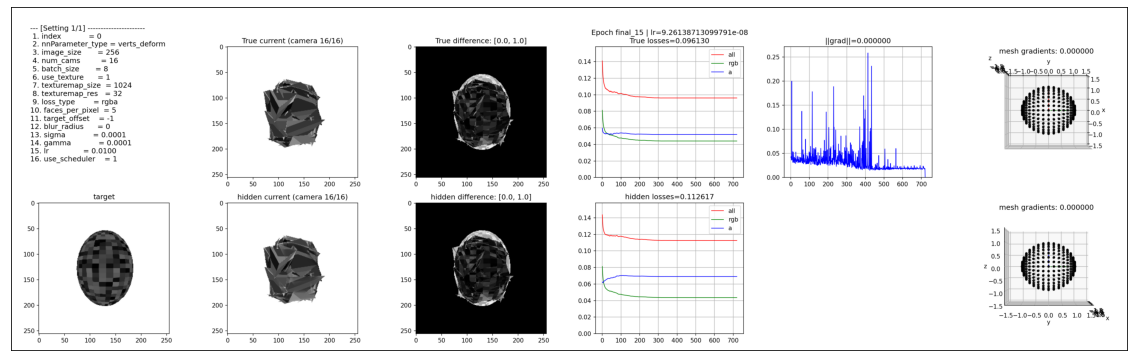

In [17]:
print(out_dir)
grad_value = model.get_grad_value(model.mesh[mesh_idx]).detach().cpu().numpy()
grad_norm = np.linalg.norm(grad_value)
grads.append(grad_norm)

loss_dict = {'all': 0.0, 'pixel': 0.0, 'silhouette': 0.0}
loss_true_dict = {'all': 0.0, 'pixel': 0.0, 'silhouette': 0.0}
image_dict = {'images': torch.empty(model.n_batch*model.batch_size, image_size, image_size, 4), 
              'target_images': torch.empty(model.n_batch*model.batch_size, image_size, image_size, 4)}
image_true_dict = {'images': torch.empty(model.n_batch*model.batch_size, image_size, image_size, 4)}

for batch_idx in range(model.n_batch):
    img_dict, img_true_dict, l_dict, l_true_dict = model(batch_idx=batch_idx, raster_settings=raster_settings, blend_params=blend_params)
    loss = l_dict['all']
    loss_pixel = l_dict['pixel']
    loss_sil = l_dict['silhouette']

    loss_true = l_true_dict['all']
    loss_pixel_true = l_true_dict['pixel']
    loss_sil_true = l_true_dict['silhouette']

    loss_dict['all'] += loss.data / model.n_batch
    loss_true_dict['all'] += loss_true.data / model.n_batch
    if loss_pixel is not None:
        loss_dict['pixel'] += loss_pixel / model.n_batch
        loss_true_dict['pixel'] += loss_pixel_true / model.n_batch
    if loss_sil is not None:
        loss_dict['silhouette'] += loss_sil / model.n_batch
        loss_true_dict['silhouette'] += loss_sil_true / model.n_batch

    i0 = batch_idx*model.batch_size
    i1 = i0 + model.batch_size
    image_dict['images'][i0:i1] = img_dict['images']
    image_dict['target_images'][i0:i1] = img_dict['target_images']
    image_true_dict['images'][i0:i1] = img_true_dict['images']

for cam_idx in range(model.n_cams):
    e = 'final_{}'.format(cam_idx)
    if loss_pixel is not None:
        image_out = image_dict['images'][cam_idx, ..., :3]
        image_out_true = image_true_dict['images'][cam_idx, ..., :3]
        image_out_target = image_dict['target_images'][cam_idx, ..., :3]
    else:
        image_out = image_dict['images'][cam_idx, ..., 3]
        image_out_true = image_true_dict['images'][cam_idx, ..., 3]
        image_out_target = image_dict['target_images'][cam_idx, ..., 3]
    image_out = image_out.detach().cpu().numpy()
    image_out_true = image_out_true.cpu().numpy()
    image_out_target = image_out_target.detach().cpu().numpy()
    plot = render_plots(True, True, out_dir, e, param_idx, p_params, cam_idx, model, lr_curr, losses, losses_true, grad_value, grads, image_out_true, image_out, image_out_target)
    plt.figure(figsize=(20, 10))
    plt.imshow(plot)
    plt.xticks([]), plt.yticks([])
    plt.show()
    


### export obj

In [11]:
out_dir = './10_data/output'
vt_path = './10_data/input/sphere.obj'
export_obj(model, out_dir, vt_path=vt_path)

[1/1] Obj exported to: ./10_data/output/learned_mesh_0.obj
